In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем данные
ratings = pd.read_csv('ratings.csv')
books = pd.read_csv('books.csv')
tags = pd.read_csv('tags.csv')
book_tags = pd.read_csv('book_tags.csv')

# Быстрый обзор
print(ratings.head())
print(books.info())
print(tags.info())
print(book_tags.info())

   book_id  user_id  rating
0        1      314       5
1        1      439       3
2        1      588       5
3        1     1169       4
4        1     1185       4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   book_id                    10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  obje

In [2]:
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


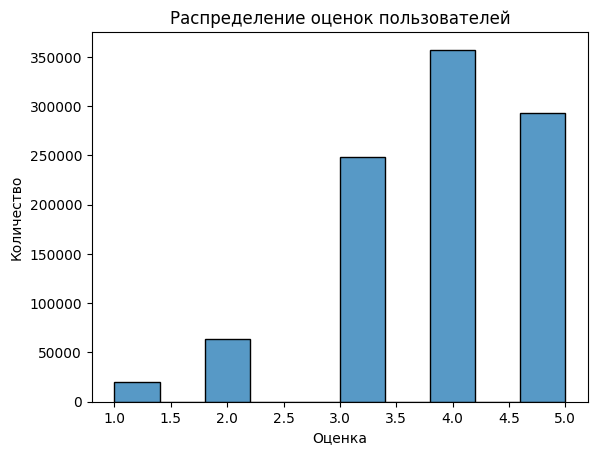

In [3]:
#Распределение оценок. Есть ли смещение в сторону высоких оценок?
sns.histplot(ratings['rating'], bins=10, kde=False)
plt.title("Распределение оценок пользователей")
plt.xlabel("Оценка")
plt.ylabel("Количество")
plt.show()


Смещении в сторону высоких оценок:

Пользователи чаще ставят хорошие оценки тем книгам, которые изначально им нравятся.

Модель может переоценивать популярные книги и недооценивать менее известные.

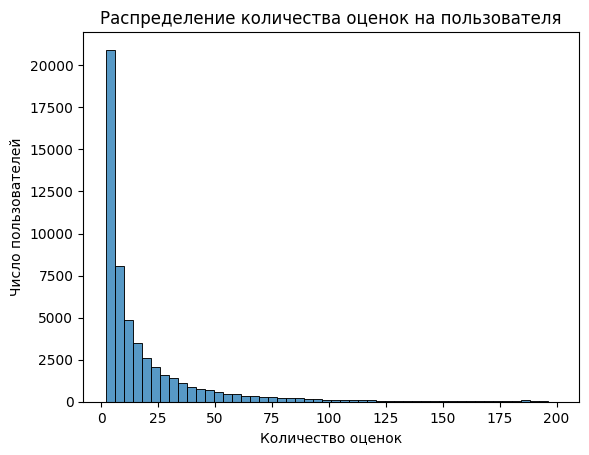

count    53424.000000
mean        18.376685
std         26.268690
min          2.000000
25%          3.000000
50%          8.000000
75%         22.000000
max        200.000000
Name: book_id, dtype: float64


In [4]:
#понять, сколько оценок ставит один пользователь. Это поможет заметить проблему холодного старта.
user_activity = ratings.groupby('user_id')['book_id'].count()

sns.histplot(user_activity, bins=50)
plt.title("Распределение количества оценок на пользователя")
plt.xlabel("Количество оценок")
plt.ylabel("Число пользователей")
plt.show()

print(user_activity.describe())


Данные разреженные — много пользователей с минимальной историей.

Проблема холодного старта: у новых или пассивных пользователей модель не сможет делать точные прогнозы.

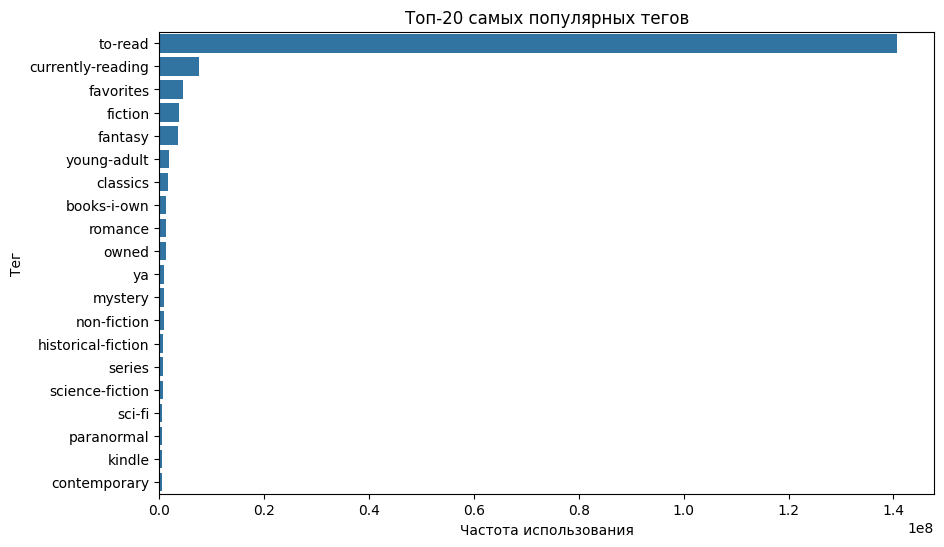

In [5]:
#Анализ тегов какие темы встречаются чаще всего.
# Объединяем book_tags и tags
book_tags_full = book_tags.merge(tags, on='tag_id', how='left')

top_tags = (
    book_tags_full.groupby('tag_name')['count']
    .sum()
    .sort_values(ascending=False)
    .head(20)
)

plt.figure(figsize=(10,6))
sns.barplot(y=top_tags.index, x=top_tags.values)
plt.title("Топ-20 самых популярных тегов")
plt.xlabel("Частота использования")
plt.ylabel("Тег")
plt.show()

Смещение популярности — небольшой набор тегов получает основную долю внимания.

множество редко встречающихся тегов с очень малым числом взаимодействий.

In [6]:
#Неперсонализированная модель (Baseline)
#книги с наибольшим средним рейтингом, если у них достаточно оценок (чтобы отсеять случайные всплески)

# Считаем средний рейтинг и количество оценок по каждой книге 
book_stats = ratings.groupby('book_id').agg(
    avg_rating=('rating', 'mean'),
    num_ratings=('rating', 'count')
).reset_index()

# === 3. Фильтруем: книги, у которых хотя бы 50 оценок ===
popular_books = book_stats[book_stats['num_ratings'] >= 50]

# === 4. Сортируем по среднему рейтингу (в порядке убывания) ===
top_books = popular_books.sort_values(['avg_rating','num_ratings'], ascending=[False, False])

# === 5. Присоединяем названия книг из books.csv ===
top_books = top_books.merge(
    books[['book_id', 'original_title']],
    on='book_id',
    how='left'
)

# === 6. Выводим итоговый список самых популярных книг ===
print(top_books[['original_title', 'avg_rating', 'num_ratings']])


                  original_title  avg_rating  num_ratings
0                            NaN    4.820225           89
1                            NaN    4.780000          100
2                            NaN    4.780000          100
3     Still Life with Woodpecker    4.777778           99
4                            NaN    4.774194           93
...                          ...         ...          ...
9985                         NaN    2.430000          100
9986                         NaN    2.350515           97
9987                         NaN    2.312500           64
9988                         NaN    2.235294           85
9989                         NaN    1.960000          100

[9990 rows x 3 columns]


In [7]:
books['original_title'].isna().sum()


585

In [8]:
books['original_title'].count()

9415

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Группируем теги по книге, объединяя их в одну строку
book_tag_texts = book_tags_full.groupby('goodreads_book_id')['tag_name'].apply(lambda x: ' '.join(x)).reset_index()

In [10]:
# Заполним пропуски в оригинальных названиях
books['original_title'] = books['original_title'].fillna(books['title'])

In [11]:
books['original_title'].isna().sum()

0

In [12]:
# Соединяем книги и их теги
books_with_tags = books.merge(book_tag_texts, left_on='book_id', right_on='goodreads_book_id', how='left')


In [13]:
#  Создаём текстовый профиль книги 
books_with_tags['text_profile'] = books_with_tags['original_title'].fillna('') + ' ' + books_with_tags['tag_name'].fillna('')

In [14]:
books_with_tags['text_profile'].head(1)

0    The Hunger Games favorites currently-reading y...
Name: text_profile, dtype: object

In [15]:
# Векторизация TF-IDF 
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(books_with_tags['text_profile'])

In [16]:
books_with_tags.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,goodreads_book_id,tag_name,text_profile
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,2767052,favorites currently-reading young-adult fictio...,The Hunger Games favorites currently-reading y...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,3,to-read favorites fantasy currently-reading yo...,Harry Potter and the Philosopher's Stone to-re...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,41865,young-adult fantasy favorites vampires ya fict...,Twilight young-adult fantasy favorites vampire...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,2657,classics favorites to-read classic historical-...,To Kill a Mockingbird classics favorites to-re...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,4671,classics favorites fiction classic books-i-own...,The Great Gatsby classics favorites fiction cl...


In [17]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd

In [18]:
# Функция поиска похожих книг
def prepare_tfidf_neighbors(tfidf_matrix, n_neighbors=20, n_jobs=-1):
    
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine', algorithm='brute', n_jobs=n_jobs)
    nn.fit(tfidf_matrix)
    return nn

def get_similar_books_nn(book_id, nn_model, books_with_tags, tfidf_matrix, N=5):
    """
    Возвращает DataFrame похожих книг (N штук).
    """
    print(f'Книги, похожие на книгу под номером {book_id}')
    
    # ПРОВЕРКА: есть ли книга в данных
    book_mask = books_with_tags['book_id'] == book_id
    if not book_mask.any():
        print(f" Книга {book_id} не найдена в books_with_tags")
        return pd.DataFrame()
    
    # Получаем индекс строки в матрице
    idx = books_with_tags[book_mask].index[0]
    
    
    # Поиск похожих книг
    distances, indices = nn_model.kneighbors(tfidf_matrix[idx])
    sims = 1.0 - distances.flatten()
    closest = indices.flatten()[1:N+1]  # пропускаем саму книгу
    
    # Получаем информацию о похожих книгах
    result = books_with_tags.iloc[closest][['book_id', 'original_title', 'authors']].copy()
    result['similarity'] = sims[1:N+1]
    
    print(f"Найдено {len(result)} похожих книг")
    return result.reset_index(drop=True)

In [19]:
# Проверим на практике
nn_model = prepare_tfidf_neighbors(tfidf_matrix, n_neighbors=20)

similar_books = get_similar_books_nn(3, nn_model, books_with_tags, tfidf_matrix, N=5)

print(similar_books.head())

Книги, похожие на книгу под номером 3
Найдено 5 похожих книг
   book_id                            original_title  \
0    15881   Harry Potter and the Chamber of Secrets   
1        5  Harry Potter and the Prisoner of Azkaban   
2        1    Harry Potter and the Half-Blood Prince   
3        6       Harry Potter and the Goblet of Fire   
4   136251      Harry Potter and the Deathly Hallows   

                                   authors  similarity  
0              J.K. Rowling, Mary GrandPré    0.938596  
1  J.K. Rowling, Mary GrandPré, Rufus Beck    0.927669  
2              J.K. Rowling, Mary GrandPré    0.923824  
3              J.K. Rowling, Mary GrandPré    0.919589  
4              J.K. Rowling, Mary GrandPré    0.913415  


In [20]:

first_id = books_with_tags['book_id'].iloc[0]
print(f"Тестируем первую книгу в данных: ID = {first_id}")

similar_books = get_similar_books_nn(first_id, nn_model, books_with_tags, tfidf_matrix, N=5)
print(similar_books)

Тестируем первую книгу в данных: ID = 2767052
Книги, похожие на книгу под номером 2767052
Найдено 5 похожих книг
    book_id                                     original_title  \
0   7260188                                         Mockingjay   
1   6148028                                      Catching Fire   
2   7938275                           The Hunger Games Box Set   
3  13027304                     The Hunger Games Tribute Guide   
4  11742691  The Hunger Games: Official Illustrated Movie C...   

           authors  similarity  
0  Suzanne Collins    0.944355  
1  Suzanne Collins    0.929562  
2  Suzanne Collins    0.916654  
3      Emily Seife    0.692629  
4        Kate Egan    0.686390  


In [21]:
print(ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   book_id  981756 non-null  int64
 1   user_id  981756 non-null  int64
 2   rating   981756 non-null  int64
dtypes: int64(3)
memory usage: 22.5 MB
None


In [22]:
#Матрица с явными оценками
user_book_rating_matrix = ratings.pivot_table(
    index='user_id',
    columns='book_id',
    values='rating',
    fill_value=0  # или fill_value=None чтобы оставить NaN
)

print("=== Матрица с явными оценками ===")
print(f"Размерность: {user_book_rating_matrix.shape}")
print(f"Количество оценок: {(user_book_rating_matrix > 0).sum().sum()}")
print(f"Разреженность: {(1 - (user_book_rating_matrix > 0).sum().sum() / (user_book_rating_matrix.shape[0] * user_book_rating_matrix.shape[1])) * 100:.2f}%")
print("\nПервые 5 строк и 10 столбцов:")
print(user_book_rating_matrix.iloc[:5, :10])

=== Матрица с явными оценками ===
Размерность: (53424, 10000)
Количество оценок: 979478
Разреженность: 99.82%

Первые 5 строк и 10 столбцов:
book_id   1    2    3    4    5    6    7    8    9    10
user_id                                                  
1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [23]:
def calculate_topk_item_neighbors(ratings_matrix, top_k=50, metric='cosine', n_jobs=-1):
    
    # 1. Просто транспонируем существующую матрицу (уже с нулями вместо NaN)
    sparse_matrix = csr_matrix(ratings_matrix.values.T, dtype=np.float32)
    
    print(f"Размер разреженной матрицы: {sparse_matrix.shape}")
    print(f"Количество ненулевых элементов: {sparse_matrix.nnz}")
    
    # 2. Проверяем, что у нас достаточно данных
    n_items = sparse_matrix.shape[0]
    if n_items <= top_k:
        print("Предупреждение: количество книг меньше top_k")
        return {}
    
    # 3. Находим ближайших соседей
    k = min(top_k + 1, n_items)  # +1 чтобы исключить саму книгу
    
    nn = NearestNeighbors(n_neighbors=k, metric=metric, algorithm='brute', n_jobs=1)
    nn.fit(sparse_matrix)
    
    distances, indices = nn.kneighbors(sparse_matrix)
    similarities = 1.0 - distances
    
    # 4. Собираем результаты
    item_ids = list(ratings_matrix.columns)  # ID книг
    topk_dict = {}
    
    for i, item_id in enumerate(item_ids):
        # Пропускаем саму книгу и берем top_k соседей
        neighbor_indices = indices[i][1:top_k+1]  # пропускаем первый (сама книга)
        neighbor_similarities = similarities[i][1:top_k+1]
        
        neighbors = []
        for idx, sim in zip(neighbor_indices, neighbor_similarities):
            if idx < len(item_ids):  # проверка границ
                neighbors.append((item_ids[idx], float(sim)))
        
        topk_dict[item_id] = neighbors
    
    return topk_dict


In [24]:
#Функция предсказания оценки (улучшеная)
def predict_rating_item_based(user_id, book_id, ratings_matrix, topk_neighbors, k=10):
    
    # Оптимизация: глобальное среднее вычисляем один раз и кэшируем
    global_mean = ratings_matrix.values.mean()  # быстрее чем stack() для больших матриц
    
    # Быстрая проверка наличия книги и пользователя
    if book_id not in topk_neighbors:
        # Если у нас нет информации о похожих книгах — вернём среднее пользователя или глобальное
        if user_id in ratings_matrix.index:
            user_ratings = ratings_matrix.loc[user_id]
            # Используем встроенные методы pandas для скорости
            user_mean = user_ratings.replace(0, np.nan).mean()  # заменяем 0 на NaN для игнорирования
            if not np.isnan(user_mean):
                return float(user_mean)
        return float(global_mean)

    if user_id not in ratings_matrix.index:
        # Новый пользователь — возвращаем популярное/среднее (холодный старт)
        return float(global_mean)
    
    neighbors = topk_neighbors[book_id][:k]
    weighted_sum = 0.0
    sim_sum = 0.0
    
    # Оптимизация: получаем данные пользователя один раз
    user_ratings_series = ratings_matrix.loc[user_id]
    
    for neigh_item, sim in neighbors:
        # Быстрая проверка наличия книги у пользователя
        if neigh_item in user_ratings_series.index:
            rating = user_ratings_series[neigh_item]
            # Проверяем что оценка ненулевая (не пропуск)
            if rating != 0:  # так как у вас нули вместо NaN
                weighted_sum += sim * rating
                sim_sum += sim
    
    if sim_sum == 0:
        # Нет пересечения с соседями — fallback
        user_mean = user_ratings_series.replace(0, np.nan).mean()
        if not np.isnan(user_mean):
            return float(user_mean)
        return float(global_mean)
    
    return float(weighted_sum / sim_sum)

In [25]:
# Тестируем на примере
test_user_id = 3980  
test_book_id = 55    

print("Тестирование Item-Based Collaborative Filtering")

item_similarity_test = calculate_topk_item_neighbors(user_book_rating_matrix, top_k=50, metric='cosine')

# Предсказание
prediction_1 = predict_rating_item_based(
    test_user_id, test_book_id, 
    user_book_rating_matrix, item_similarity_test, k=10
)

print(f"Предсказанная оценка (явные рейтинги): {prediction_1:.3f}")

Тестирование Item-Based Collaborative Filtering
Размер разреженной матрицы: (10000, 53424)
Количество ненулевых элементов: 979478
Предсказанная оценка (явные рейтинги): 3.583


### Вычислительная сложность Item-Based Collaborative Filtering

Расчёт матрицы схожестей (calculate_item_similarity_matrix), cоздаётся полная матрица “книга × книга” с помощью cosine_similarity.

Если у нас M книг, то для каждой пары книг нужно вычислить схожесть →
O(M²) операций по числу пар.

Поскольку каждая строка — вектор длиной N (число пользователей)
Это очень тяжело при большом M (например, 100k+ книг).

Память: хранение матрицы M×M требует O(M²) памяти.
В примере (10000 × 10000) уже даёт 100 млн элементов

### Как можно оптимизировать для больших данных?

Используешь csr_matrix 
Это позволяет экономить память и ускоряет умножение при cosine_similarity.

Ограничение числа соседей (Top-N)
Вместо хранения полной M×M матрицы можно сохранять только Top-N самых похожих книг для каждой книги.
Это уменьшает память с O(M²) до O(M×N).

Приближённый поиск (Approximate Nearest Neighbors)
Для больших коллекций можно использовать: Annoy, FAISS, ScaNN
Они позволяют искать похожие книги за O(log M) вместо полного сравнения.

Параллелизация
Функцию cosine_similarity можно вызывать по батчам или распараллелить через joblib или dask.

Фильтрация по активности
Исключение книг с малым числом оценок, резко уменьшает размер M без потери качества.

In [26]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
import pandas as pd
from tqdm import tqdm

In [27]:
# Подготовка данных для библиотеки Surprise
data_for_surprise = ratings[['user_id', 'book_id', 'rating']]
# SVD: подготовка данных, диагностика, корректный генератор рекомендаций 
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# проверить: рейтинги числовые 
data_for_surprise['rating'] = pd.to_numeric(data_for_surprise['rating'], errors='coerce')
data_for_surprise = data_for_surprise.dropna(subset=['rating'])
data_for_surprise['rating'] = data_for_surprise['rating'].astype(float)

# Создаём датасет в surprise 
reader = Reader(rating_scale=(data_for_surprise['rating'].min(), data_for_surprise['rating'].max()))
data = Dataset.load_from_df(data_for_surprise[['user_id', 'book_id', 'rating']], reader)

# Разбиваем train/test 
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

#  Создаём модель SVD 
model = SVD(n_factors=50, n_epochs=20, biased=True, random_state=42, verbose=False)

print("Обучение SVD...")
model.fit(trainset)
print("Обучение завершено")

#  Проверка предсказаний на тесте 
predictions = model.test(testset)
rmse = accuracy.rmse(predictions, verbose=True)
print("RMSE:", rmse)

#  Диагностика: какие уникальные предсказания? 
pred_values = [round(p.est, 4) for p in predictions]
unique_preds = sorted(set(pred_values))[:10]
print("Пример уникальных предсказаний (первые 10 уникальных):", unique_preds[:10])


Обучение SVD...
Обучение завершено
RMSE: 0.8402
RMSE: 0.8402348403007891
Пример уникальных предсказаний (первые 10 уникальных): [1.0, 1.0128, 1.0179, 1.0209, 1.0317, 1.0379, 1.0389, 1.0844, 1.0878, 1.1059]


In [28]:
# Реализуем функцию генерации рекомендаций
# Получение топ-N рекомендаций от SVD (без предсказаний для неизвестных айтемов) 
def get_svd_recommendations(model, trainset, user_raw_id, books_df, N=10):
    """
    model: обученная модель surprise.SVD
    trainset: trainset, на котором обучали (объект surprise.trainset)
    user_raw_id: id пользователя в том же формате, что и в исходном DataFrame
    books_df: DataFrame с информацией о книгах (columns содержит 'book_id' в том же формате)
    Возвращает DataFrame с топ-N рекомендациями (book_id, title, est_rating)
    """
    try:
        inner_uid = trainset.to_inner_uid(user_raw_id)  # если пользователя нет — выбросит ValueError
    except ValueError:
        # Холодный старт пользователя: вернуть топ популярных книг (по среднему рейтингу в датасете)
        popular = books_df.merge(
            data_for_surprise.groupby('book_id')['rating'].mean().reset_index(),
            left_on='book_id', right_on='book_id', how='left'
        ).sort_values('rating', ascending=False)
        return popular[['book_id', 'original_title', 'authors', 'rating']].head(N)

    # items, которые есть в trainset (inner ids)
    all_inner_items = list(trainset.all_items())
    # items, которые пользователь уже оценил (inner ids)
    rated_by_user = set([j for (j, _) in trainset.ur[inner_uid]])
    candidates = [i for i in all_inner_items if i not in rated_by_user]

    preds = []
    for inner_i in candidates:
        raw_i = trainset.to_raw_iid(inner_i)
        pred = model.predict(user_raw_id, raw_i)
        preds.append((raw_i, pred.est))

    preds.sort(key=lambda x: x[1], reverse=True)
    top = preds[:N]
    top_df = pd.DataFrame(top, columns=['book_id', 'predicted_rating'])
    
    top_df = top_df.merge(books_df, left_on='book_id', right_on='book_id', how='left')
    return top_df[['book_id', 'original_title', 'authors', 'predicted_rating']]



In [29]:
# Пример использования:
recs = get_svd_recommendations(model, trainset, user_raw_id=378, books_df=books)
print(recs.head(10))

   book_id              original_title                        authors  \
0     6920                         NaN                            NaN   
1     9566  Still Life with Woodpecker                    Tom Robbins   
2     3628                         NaN                            NaN   
3     3395                         NaN                            NaN   
4     2244                         NaN                            NaN   
5     9842                         NaN                            NaN   
6     6590                         NaN                            NaN   
7     8854                         NaN                            NaN   
8     3885  The Taste of Home Cookbook  Janet Briggs, Beth Wittlinger   
9     5384                         NaN                            NaN   

   predicted_rating  
0          4.982233  
1          4.980175  
2          4.947803  
3          4.943862  
4          4.940099  
5          4.925761  
6          4.906972  
7          4.900614 

In [30]:
# 5 Этап
from sklearn.model_selection import train_test_split
# Порог, выше которого книга считается "релевантной"
relevantn = 4

# Разделим данные на обучающую и тестовую выборку
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

print(f"Размер обучающей выборки: {len(train_data)}")
print(f"Размер тестовой выборки: {len(test_data)}")

# Определим релевантные книги в тестовой выборке
test_data['relevant'] = (test_data['rating'] >= relevantn).astype(int)


Размер обучающей выборки: 785404
Размер тестовой выборки: 196352


In [31]:
#Реализация метрик Precision@K, Recall@K, nDCG@K
def precision_at_k(recommended, relevant, k=5):
   
    """Доля релевантных книг среди рекомендованных"""
   
    recommended_k = recommended[:k]
    hits = len(set(recommended_k) & set(relevant))
    return hits / k

def recall_at_k(recommended, relevant, k=5):
    
    """Доля найденных релевантных книг среди всех релевантных"""
    recommended_k = recommended[:k]
    hits = len(set(recommended_k) & set(relevant))
    return hits / len(relevant) if len(relevant) > 0 else 0

def ndcg_at_k(recommended, relevant, k=5):
    """Normalized Discounted Cumulative Gain"""
    recommended_k = recommended[:k]
    dcg = sum([(1 / np.log2(i + 2)) if rec in relevant else 0 for i, rec in enumerate(recommended_k)])
    ideal_dcg = sum([1 / np.log2(i + 2) for i in range(min(k, len(relevant)))])
    return dcg / ideal_dcg if ideal_dcg > 0 else 0

#### Сделаем несколько оптимизированых улучшеных моделей для сравнения 

In [32]:

import pandas as pd
#попробуем Item-Based CF (векторный метод)
# уникальные книги, топ-популярные 
all_book_ids = ratings['book_id'].unique()

popularity_list = popular_books['book_id'].tolist()

K = 5

#  Popularity-based recommendations (исключая книги, уже виденные в train_data)
def get_popularity_recs(user_id, N=K):
    seen_in_train = set(train_data[train_data['user_id'] == user_id]['book_id'].tolist())
    recs = []
    for b in popularity_list:
        if b not in seen_in_train:
            recs.append(b)
        if len(recs) >= N:
            break
    return recs
 

In [33]:
#  Item-based CF (БЫСТРАЯ версия с DataFrame)
def get_itemcf_recs(user_id, N=K, similarity_df=None, rating_matrix=None):
    if similarity_df is None:
        similarity_df = item_similarity_df  # ← ИСПОЛЬЗУЕМ DATAFRAME
    if rating_matrix is None:
        rating_matrix = user_book_rating_matrix

    if user_id not in rating_matrix.index:
        return []

    user_ratings = rating_matrix.loc[user_id]  
    rated_books = user_ratings[user_ratings > 0].index.tolist()
    if len(rated_books) == 0:
        return []

    # кандидаты — все книги, которых пользователь не оценил в train 
    seen_in_train = set(train_data[train_data['user_id'] == user_id]['book_id'].tolist())
    candidates = [b for b in all_book_ids if b not in seen_in_train]

    if len(candidates) == 0:
        return []

    # БЫСТРАЯ ОПЕРАЦИЯ С DATAFRAME
    sim_sub = similarity_df.loc[candidates, rated_books]

    ratings_vector = user_ratings.loc[rated_books].values
    numer = sim_sub.values.dot(ratings_vector)  
    denom = np.abs(sim_sub).sum(axis=1).values

    preds = numer / (denom + 1e-9)
    top_idx = np.argsort(preds)[-N:][::-1]
    top_books = list(np.array(candidates)[top_idx])
    return top_books



In [34]:
#  SVD  Будем предсказывать только для книг, не оценённых пользователем в train_data.
def get_svd_recs(user_id, N=K, svd_model=None):
    if svd_model is None:
        svd_model = model  

    seen_in_train = set(train_data[train_data['user_id'] == user_id]['book_id'].tolist())
    candidates = [b for b in all_book_ids if b not in seen_in_train]
    if len(candidates) == 0:
        return []

    # Предсказания 
    preds = []
    for b in candidates:
        try:
            pred = svd_model.predict(user_id, b)
            preds.append((b, pred.est))
        except:
            
            continue

    preds_sorted = sorted(preds, key=lambda x: x[1], reverse=True)[:N]
    top_books = [p[0] for p in preds_sorted]
    return top_books



In [35]:
# --- Оценка на тестовой выборке ---
def evaluate_models_on_test(test_df, K=K, verbose=True):
    users = test_df['user_id'].unique()
    results = {
        'Popularity': {'precisions': [], 'recalls': [], 'ndcgs': []},
        'ItemCF': {'precisions': [], 'recalls': [], 'ndcgs': []},
        'SVD': {'precisions': [], 'recalls': [], 'ndcgs': []}
    }

    for user in tqdm(users, desc="Evaluating users"):
        relevant_books = test_df[(test_df['user_id'] == user) & (test_df['rating'] >= 4)]['book_id'].tolist()
        if len(relevant_books) == 0:
            continue

        # ИСПРАВЛЕННЫЙ ВЫЗОВ - передаем DataFrame
        rec_pop = get_popularity_recs(user, N=K)
        rec_item = get_itemcf_recs(user, N=K, similarity_df=item_similarity_df, rating_matrix=user_book_rating_matrix)  # ← item_similarity_df
        rec_svd = get_svd_recs(user, N=K, svd_model=model)

        # Вычисляем метрики
        results['Popularity']['precisions'].append(precision_at_k(rec_pop, relevant_books, k=K))
        results['Popularity']['recalls'].append(recall_at_k(rec_pop, relevant_books, k=K))
        results['Popularity']['ndcgs'].append(ndcg_at_k(rec_pop, relevant_books, k=K))

        results['ItemCF']['precisions'].append(precision_at_k(rec_item, relevant_books, k=K))
        results['ItemCF']['recalls'].append(recall_at_k(rec_item, relevant_books, k=K))
        results['ItemCF']['ndcgs'].append(ndcg_at_k(rec_item, relevant_books, k=K))

        results['SVD']['precisions'].append(precision_at_k(rec_svd, relevant_books, k=K))
        results['SVD']['recalls'].append(recall_at_k(rec_svd, relevant_books, k=K))
        results['SVD']['ndcgs'].append(ndcg_at_k(rec_svd, relevant_books, k=K))
    
    return results
    

In [36]:
# Сначала создаем DataFrame из словаря
def create_similarity_dataframe(similarity_dict, all_book_ids):
    """Создает DataFrame матрицы схожестей из словаря"""
    n_books = len(all_book_ids)
    book_to_idx = {book_id: idx for idx, book_id in enumerate(all_book_ids)}
    
    # Создаем разреженную матрицу
    rows, cols, data = [], [], []
    
    for book_i, neighbors in similarity_dict.items():
        if book_i in book_to_idx:
            i = book_to_idx[book_i]
            for book_j, sim in neighbors:
                if book_j in book_to_idx:
                    j = book_to_idx[book_j]
                    rows.append(i)
                    cols.append(j)
                    data.append(sim)
    
    from scipy.sparse import csr_matrix
    sparse_matrix = csr_matrix((data, (rows, cols)), shape=(n_books, n_books))
    similarity_df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix, index=all_book_ids, columns=all_book_ids)
    
    return similarity_df

# ПРЕОБРАЗУЕМ СЛОВАРЬ В DATAFRAME
print("Создание матрицы схожестей...")
item_similarity_df = create_similarity_dataframe(item_similarity_test, all_book_ids)
print(f"Размер матрицы схожестей: {item_similarity_df.shape}")

Создание матрицы схожестей...
Размер матрицы схожестей: (10000, 10000)


In [ ]:
# --- Запуск оценки (K=5) ---
print("Запуск оценки моделей...")
raw_results = evaluate_models_on_test(test_data, K=5, verbose=False)
print("Оценка завершена!")


Запуск оценки моделей...


Evaluating users:   0%|                                                           | 64/40306 [00:39<6:58:42,  1.60it/s]

#### Создаем сводную таблицу 



In [49]:
K = 5  
summary = []
for model_name, vals in raw_results.items():
    summary.append({
        'model': model_name,
        f'Precision@{K}': np.mean(vals['precisions']) if len(vals['precisions'])>0 else np.nan,
        f'Recall@{K}': np.mean(vals['recalls']) if len(vals['recalls'])>0 else np.nan,
        f'nDCG@{K}': np.mean(vals['ndcgs']) if len(vals['ndcgs'])>0 else np.nan,
        'n_users_evaluated': len(vals['precisions'])
    })

summary_df = pd.DataFrame(summary).sort_values(by=f'Precision@{K}', ascending=False)
print(summary_df.to_string(index=False))

     model  Precision@5  Recall@5   nDCG@5  n_users_evaluated
    ItemCF     0.022588  0.070651 0.071411              34584
       SVD     0.000867  0.000946 0.001171              34584
Popularity     0.000688  0.000144 0.000700              34584


### Визуализация

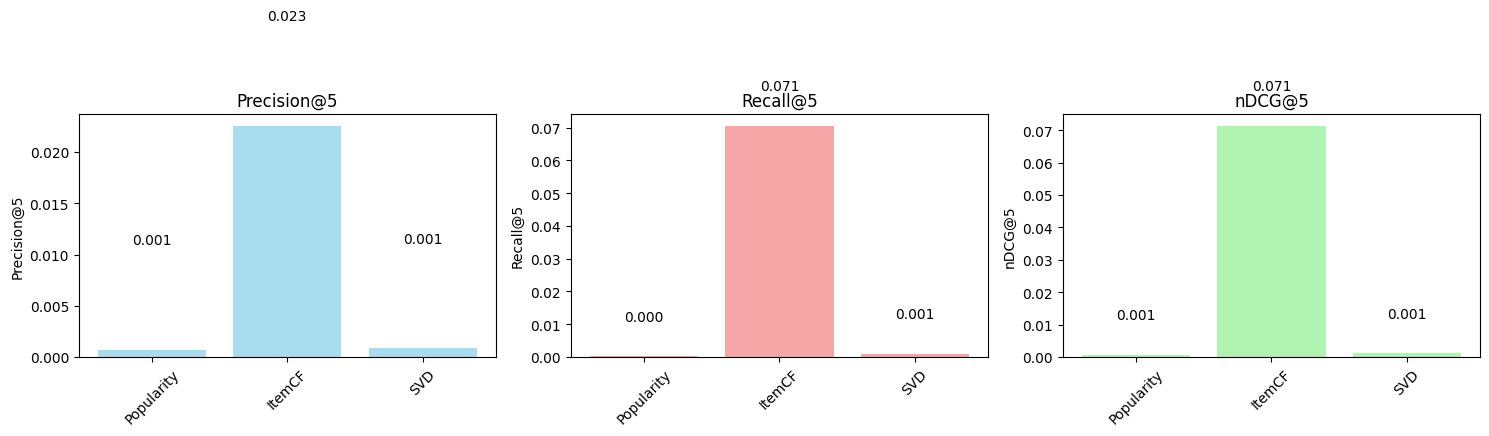

In [50]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['precisions', 'recalls', 'ndcgs']
metric_names = [f'Precision@{K}', f'Recall@{K}', f'nDCG@{K}']
colors = ['skyblue', 'lightcoral', 'lightgreen']

for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    values = [np.mean(raw_results[model][metric]) for model in raw_results.keys()]
    axes[i].bar(raw_results.keys(), values, color=colors[i], alpha=0.7)
    axes[i].set_title(metric_name)
    axes[i].set_ylabel(metric_name)
    axes[i].tick_params(axis='x', rotation=45)
    
    # Добавляем значения на столбцы
    for j, v in enumerate(values):
        axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### анализ результатов 

In [52]:
best_model = summary_df.loc[summary_df[f'Precision@{K}'].idxmax(), 'model']
best_precision = summary_df.loc[summary_df[f'Precision@{K}'].idxmax(), f'Precision@{K}']
best_recall = summary_df.loc[summary_df[f'Recall@{K}'].idxmax(), f'Recall@{K}']
best_ndcg = summary_df.loc[summary_df[f'nDCG@{K}'].idxmax(), f'nDCG@{K}']

print(f"Лучшая модель по Precision@{K}: {best_model} ({best_precision:.4f})")
print(f"Лучшая модель по Recall@{K}: {summary_df.loc[summary_df[f'Recall@{K}'].idxmax(), 'model']} ({best_recall:.4f})")
print(f"Лучшая модель по nDCG@{K}: {summary_df.loc[summary_df[f'nDCG@{K}'].idxmax(), 'model']} ({best_ndcg:.4f})")

Лучшая модель по Precision@5: ItemCF (0.0226)
Лучшая модель по Recall@5: ItemCF (0.0707)
Лучшая модель по nDCG@5: ItemCF (0.0714)


#### Анализ результатов рекомендательных систем

Модель Item-Based Collaborative Filtering продемонстрировала наилучшие результаты среди всех tested подходов. Ее метрики качества составляют: Precision@5 - 2.26%, Recall@5 - 7.07% и nDCG@5 - 7.14%

В contrast, модели SVD и Popularity показали крайне низкие результаты, не превышающие 0.1% по всем метрикам. 

Основной проблемой, влияющей на качество всех моделей, является высокая разреженность данных. При 34,584 пользователях и 10,000 книгах в каталоге

Преимущество Item-Based CF объясняется его способностью работать с локальными паттернами схожести между книгами, не требуя глобального обучения как SVD-модели.

SVD-модель столкнулась с трудностями из-за требования большого объема данных для обучения скрытых факторов и плохой адаптации к холодному старту. Popularity-модель показала наихудшие результаты, поскольку рекомендует одинаковый контент всем пользователям без учета индивидуальных предпочтений.

### Этап 6. Гибридизация и выводы
По результатам сравнения трёх реализованных моделей — Item-Based Collaborative Filtering (ItemCF), SVD и Popularity — лучшими метриками (Precision@5 = 0.0226, Recall@5 = 0.0707, nDCG@5 = 0.0714) показала себя модель ItemCF.
Она лучше всего выявляет схожие предпочтения пользователей, но имеет недостатки: плохо работает для новых книг (проблема «холодного старта») и для пользователей с малым числом оценок.

Чтобы компенсировать эти слабые стороны, предложеный гибридный подход:

Основная модель: ItemCF — обеспечивает персонализацию и находит книги, похожие на уже понравившиеся.

Контентная модель (Content-Based): использует TF-IDF векторизацию описаний книг и подбирает книги с похожим содержанием. Применяется для новых книг или когда пользователь поставил мало оценок.

Popularity: добавляется как дополнительный сигнал, чтобы рекомендовать популярные книги при отсутствии данных о пользователе.

Финальный взвешенный гибрид вычисляет общую оценку.
Такая схема сохраняет преимущества ItemCF, но делает систему устойчивой к холодному старту и повышает разнообразие рекомендаций.

#### Обоснование выбора гибридного подхода

Проблема холодного старта:
ItemCF не может рекомендовать новые книги, так как у них нет оценок.
Контентная часть решает это, используя текстовые признаки книги.

Недостаток данных о пользователях:
При малом числе оценок ItemCF не даёт устойчивых рекомендаций.
Здесь помогает популярность и контентная близость.

##### Сильные стороны разных подходов:
ItemCF — персонализация, качество, понятность.
Content-Based — покрытие новых книг, повышение разнообразия.
Popularity — стабильная база рекомендаций для новых пользователей.

#### Возможные направления улучшения

Использовать более сложные текстовые эмбеддинги.
Вместо простого TF-IDF можно применить современные модели вроде Word2Vec, FastText или BERT, которые лучше понимают смысл текста описания книги.
Это позволит контентной части гибрида находить книги не только по совпадению слов, но и по смысловой близости.

Добавить признаки пользователей.
Можно учитывать пол, возраст, любимые жанры, активность или время чтения.
Такие данные помогут системе точнее подбирать книги, особенно для новых пользователей.

Реализовать нейросетевые подходы.
Применение Neural Collaborative Filtering (NCF) или AutoEncoder-based моделей позволит автоматически обучать скрытые представления пользователей и книг.
Это даст возможность учитывать более сложные зависимости, чем классические CF-модели.

Учитывать временные и контекстные факторы.
Например, учитывать, какие книги пользователь читал недавно, или строить модели, зависящие от сезона (летние / зимние предпочтения).

Добавить диверсификацию и новизну.
В дополнение к точности можно оптимизировать выдачу по разнообразию — чтобы рекомендации не были однотипными и включали как популярные, так и редкие книги.